# Missing featues

In [101]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
sns.set_theme(style="darkgrid")

In [3]:
df = pd.read_csv("dataset/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Data preparation

In [4]:
df.loc[:,'Glucose':'BMI'] = df.loc[:,'Glucose':'BMI'].replace(0,np.nan)
print("Number of defective records: %d" % df[df.isnull().sum(axis=1) > 0].shape[0])
print("Number of defective values in columns:")
print(df.isna().sum())

Number of defective records: 376
Number of defective values in columns:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [38]:
means_df = df.fillna(df.mean()).astype({
    "Pregnancies": "int32",
    "Glucose": "int32",
    "BloodPressure": "int32",
    "SkinThickness": "int32",
    "Insulin": "int32",
    "BMI": "int32",
    "DiabetesPedigreeFunction": "float",
    "Age": "int32",
    "Outcome": "category"
})
means_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,155,33,0.627,50,1
1,1,85,66,29,155,26,0.351,31,0
2,8,183,64,29,155,23,0.672,32,1
3,1,89,66,23,94,28,0.167,21,0
4,0,137,40,35,168,43,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32,0.171,63,0
764,2,122,70,27,155,36,0.340,27,0
765,5,121,72,23,112,26,0.245,30,0
766,1,126,60,29,155,30,0.349,47,1


## Feature estimation

Estimate missing values using linear regression

In [5]:
# sorted cols based on missing value count
missing_feature_cols = ["Insulin", "SkinThickness", "BloodPressure", "BMI", "Glucose"]

In [111]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm

mse_scorer = make_scorer(mean_squared_error)

### Approach #1

In [108]:
result_df = df.copy()
for col in tqdm(missing_feature_cols):
    missing_mask = df[col].isna().values
    non_missing_mask = ~missing_mask
    train_df = means_df[non_missing_mask]
    test_df = means_df[missing_mask]
    
    X_train = train_df[train_df.columns.difference([col])].values.astype(np.float32)
    X_test  = test_df[test_df.columns.difference([col])].values.astype(np.float32)
    y_train = train_df[col].values.astype(np.float32)
    
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test  = X_scaler.transform(X_test)
    #y_train = y_scaler.fit_transform(y_train.reshape((-1, 1))).ravel()
    
    result = cross_val_score(LinearRegression(), X_train, y_train, cv=10, scoring=mse_scorer)
    print(f"LR for column {col}, achieved mean CV score (MSE): {np.mean(result)}")
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    #y_pred = y_scaler.inverse_transform(y_pred)

    result_df.loc[missing_mask, col] = y_pred.astype(np.int32)
result_df.to_csv(os.path.join(".", "dataset", "lr_diabetes_1.csv"), index=False)

100%|██████████| 5/5 [00:00<00:00, 78.42it/s]

LR for column Insulin, achieved mean CV score (MSE): 9635.6978515625
LR for column SkinThickness, achieved mean CV score (MSE): 64.52113037109375
LR for column BloodPressure, achieved mean CV score (MSE): 125.08867721557617
LR for column BMI, achieved mean CV score (MSE): 30.33211898803711
LR for column Glucose, achieved mean CV score (MSE): 589.8556304931641


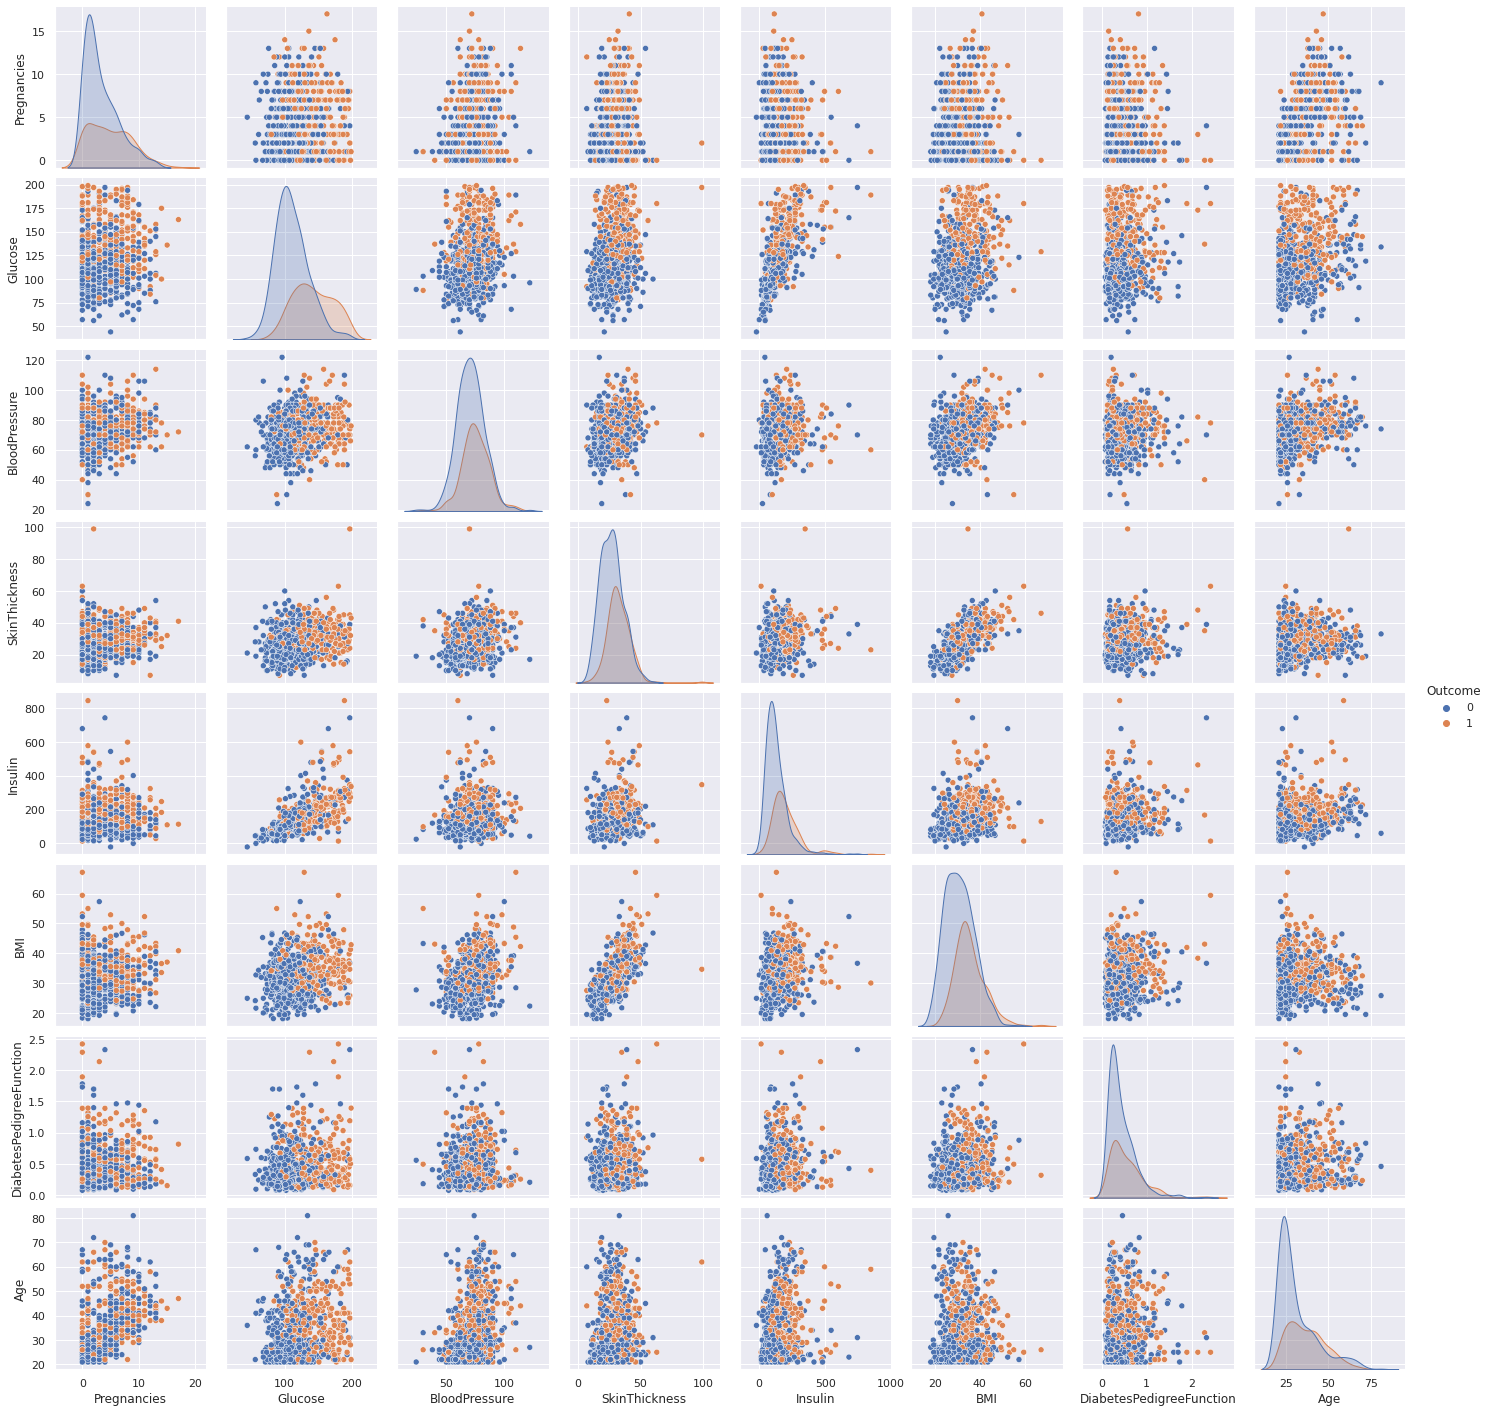

In [109]:
sns.pairplot(result_df, hue="Outcome");

### Approach #2

Train on classifiers using data generated by previous ones

In [107]:
result_df = means_df.copy()
for col in tqdm(missing_feature_cols):
    missing_mask = df[col].isna().values
    non_missing_mask = ~missing_mask
    train_df = result_df[non_missing_mask]
    test_df = result_df[missing_mask]
    
    X_train = train_df[train_df.columns.difference([col])].values.astype(np.float32)
    X_test  = test_df[test_df.columns.difference([col])].values.astype(np.float32)
    y_train = train_df[col].values.astype(np.float32)
    
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test  = X_scaler.transform(X_test)
    #y_train = y_scaler.fit_transform(y_train.reshape((-1, 1))).ravel()
    
    result = cross_val_score(LinearRegression(), X_train, y_train, cv=10, scoring=mse_scorer)
    print(f"LR for column {col}, achieved mean CV score (MSE): {np.mean(result)}")
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    #y_pred = y_scaler.inverse_transform(y_pred)

    result_df.loc[missing_mask, col] = y_pred
result_df.to_csv(os.path.join(".", "dataset", "lr_diabetes_2.csv"), index=False)

100%|██████████| 5/5 [00:00<00:00, 62.30it/s]

LR for column Insulin, achieved mean CV score (MSE): 9635.6978515625
LR for column SkinThickness, achieved mean CV score (MSE): 64.44817695617675
LR for column BloodPressure, achieved mean CV score (MSE): 124.1610954284668
LR for column BMI, achieved mean CV score (MSE): 21.80558547973633
LR for column Glucose, achieved mean CV score (MSE): 405.0614410400391


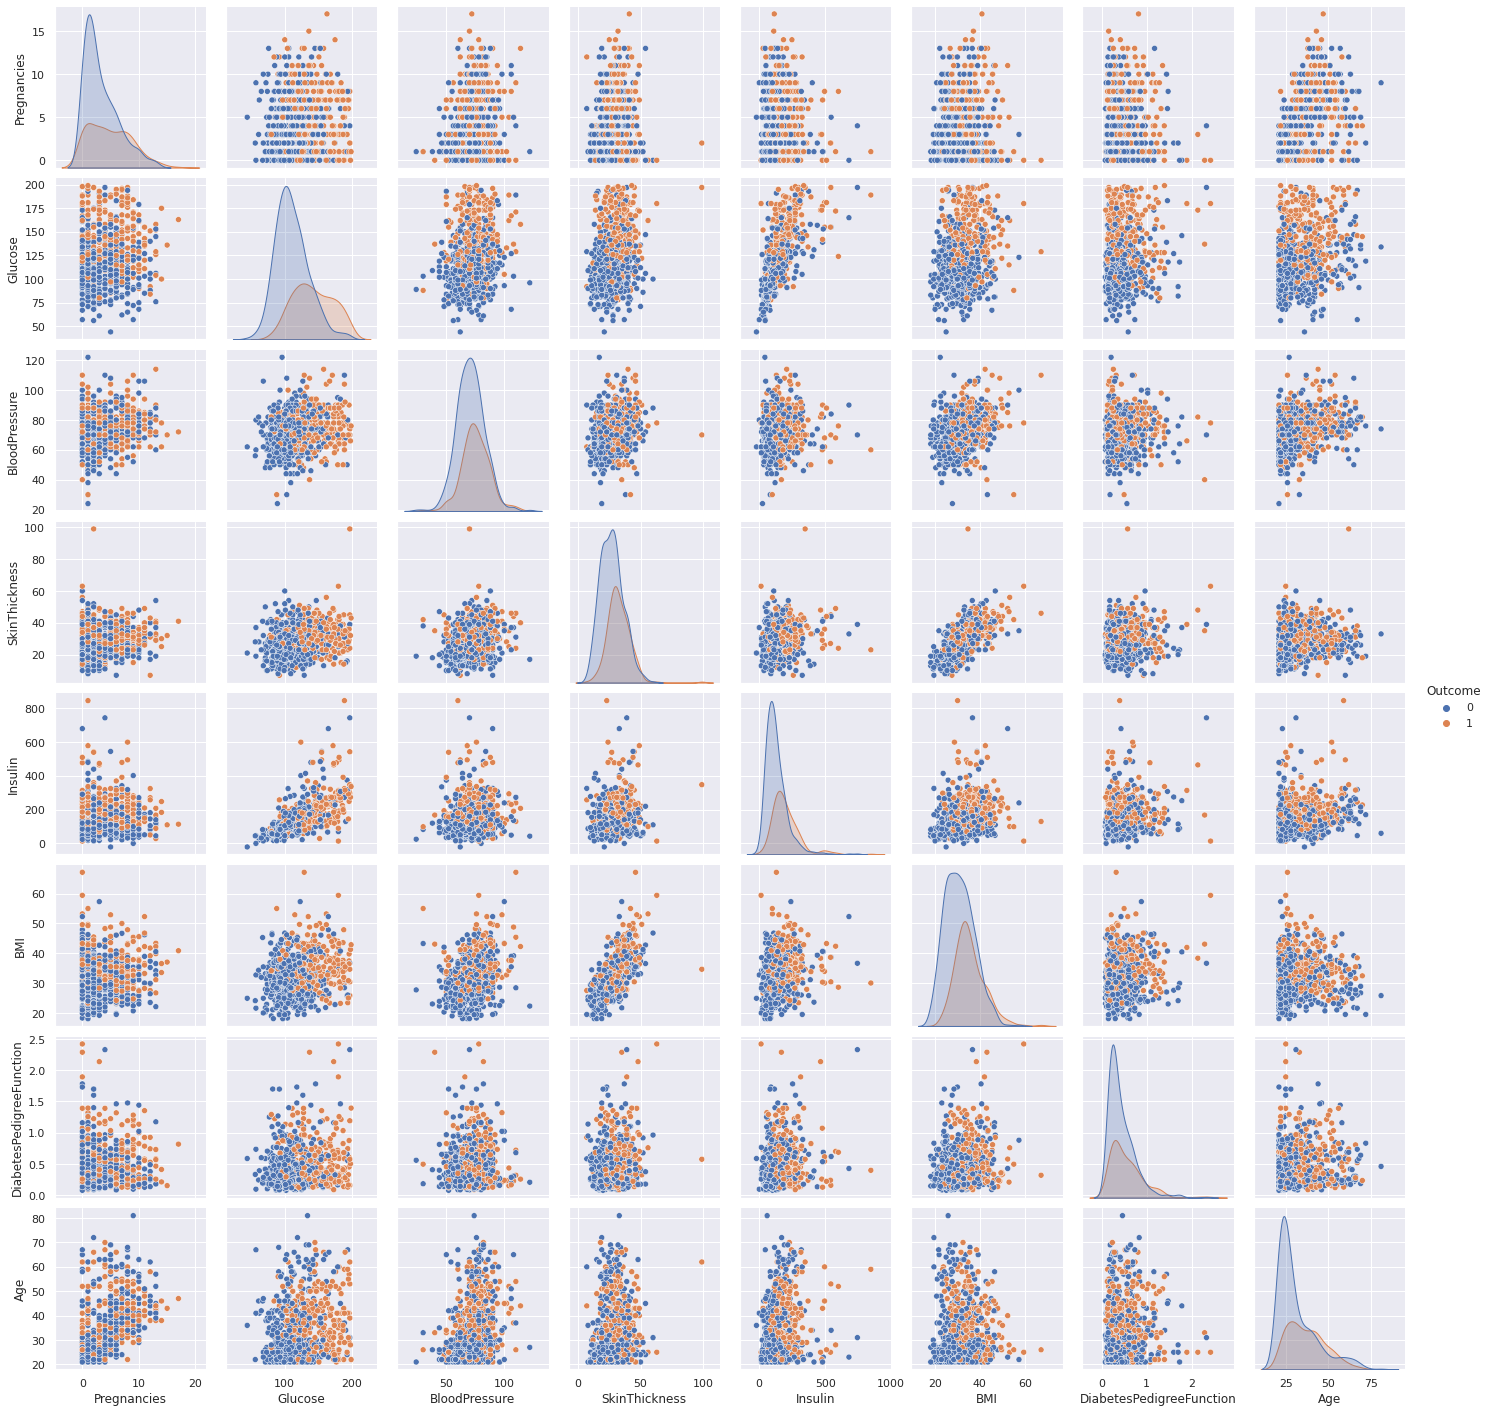

In [110]:
sns.pairplot(result_df, hue="Outcome");